<a href="https://colab.research.google.com/github/tsiligardi/PRA3024-Analysis-of-big-data-in-physics/blob/main/GWDA_Ex_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem 3**

In [1]:
import sys
!{sys.executable} -m pip install lalsuite pycbc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 KB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 16.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.2/201.2 KB 18.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 73.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 KB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
    

In [2]:
#Import the usefull libraries
%matplotlib inline
import pylab
import lal
from pycbc.filter import highpass,matched_filter,sigmasq
from pycbc.conversions import mass1_from_mchirp_q
from pycbc.catalog import Merger
from pycbc.frame import read_frame
from pycbc.filter import resample_to_delta_t, highpass
import numpy as np
from pycbc import types
from pycbc.waveform import get_td_waveform,get_fd_waveform
from pycbc.waveform import td_approximants, fd_approximants
import pycbc.psd
from pycbc.psd import interpolate


**Part 1**
<br>The horizon distance of a GW detector is defined as a distance to the source for which
the accumulated signal power (optimal SNR) is equal to a detection threshold of SNR
(ρmin = 8) when the source is located overhead (θ = 0,π). Plot the horizon distance
for Advanced LIGO detector (assuming ’H1’ noise PSD) assuming a set of equal mass
binary with a range of component masses between 5 to 500. In this plot, you can
assume that X-axis and Y-axis represent the total mass of the binary and horizon
distance, respectively

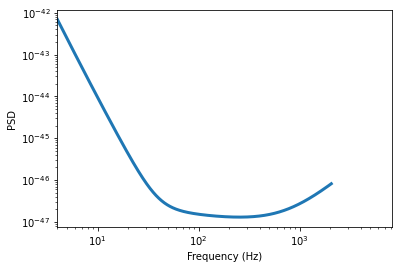

In [3]:
#First, I need to generate the psd for advanced Ligo detector
# set up all the parameters
flow = 4   
delta_f = 1.0 / 16 
flen = int(2048.0/ (delta_f)) + 1
#calculating the psd 
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow) 
#set the value outside the frequency range to infinity
psd.data[:int(flow/delta_f)] = np.inf  
psd.data[-1] = np.inf 
#plotting
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='aLIGOZeroDetHighPower');
pylab.xlim(xmin=flow, xmax=8192);
pylab.xlabel('Frequency (Hz)');
pylab.ylabel('PSD');


Using that $D∝ \frac{1}{\rho}$ and knowind that the horizon ($D_H$) is the distance that correspond to $\rho=8$, one gets: $D_H=\frac{D_1*\rho_1}{8}$, In this case, I will calculate $\rho_1$ for a range of masses at $D_1=1000Mp$. Since I will have to repeat the exercise again, just with different PSDs, is useful to define a function that, given a range of masses and the PSDs, returns me the Horizon distance.

In [4]:
def get_horizon_distances(masses,psd,delta_f,flow):
  D_Hs=[]
  for m in masses:
  #generating the waveform
    hp, hc = get_fd_waveform(approximant="TaylorF2", 
                         mass1=m, 
                         mass2=m, 
                         delta_f=delta_f , 
                         distance = 1000,  
                         f_lower=flow,)
    #calculating the SNR
    SNR=(sigmasq(hp,psd))**0.5
    #Calculating the horizon distance
    D_H=(1000*(SNR))/8 
    D_Hs.append(D_H)
  return D_Hs

In [5]:
#Creating a range of masses:
masses=np.arange(5,500,1)
#getting the horizon distances
DH_aligo=get_horizon_distances(masses,psd,delta_f,flow)

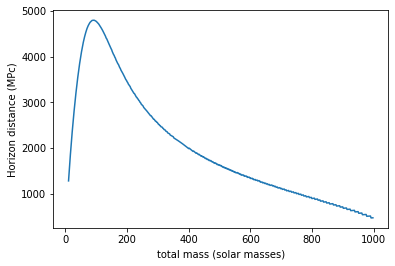

In [6]:
mass_tot=2*masses #calculating the total mass
#plotting
pylab.plot(mass_tot,DH_aligo);
pylab.xlabel('total mass (solar masses)');
pylab.ylabel('Horizon distance (MPc)');

**Part 2** <br>
From the plot of horizon distance, you will see the curve reaches its maximum value for
a massive black hole. After that, the horizon distance decreases over mass. Can you
explain why do we see such behavior? What can you interpret from the point of view
of the detector’s capability to detect GWs from the compact binary merger?

**ANSWER**: <br>The formula above shows that the Horizon distance depends on $\rho$. In addition, we know that $\rho^2=4\int _0^{∞}\frac{|\tilde{h}(f)|^2}{S_h(f)}$, where $S_h(f)$ is the noise power spectral denisty. 
Therefore, the horizon distance is proportional to the square root of the inverse of the noise power spectral density (i.e., the higher the power noise spectral density, the lower the horizon distance). <br>
Signals generated by massive systems have a higher amplitude, but they also generate lower frequencies (source: https://www.ligo.org/science/Publication-GW190521/), at which the power spectral density is higher (as can be seen from the graph). Therefore, after a certain value of the mass, the value of the PSD is so high that counteracts the big amplitude of the signal, making the horizon distance decrease. 

**Part 3** <br>
Repeat the same analysis for the future generation gravitational wave detectors (Ein-
stein telescope) and make a plot for horizon distance versus the total mass of the system.
Compare this plot with the previous plot for the Advanced LIGO detector and make
your conclusion.

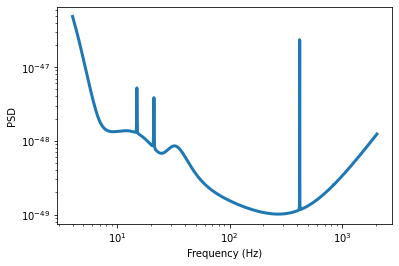

In [7]:
#deteming the power spectral densities for the einstein telescope
psd_einstein = pycbc.psd.EinsteinTelescopeP1600143(flen, delta_f, flow)
#set the value outside the frequency range to infinity 
psd_einstein.data[:int(flow/delta_f)] = np.inf 
psd_einstein.data[-1] = np.inf 
#plotting
pylab.loglog(psd_einstein.sample_frequencies, psd_einstein, linewidth=3, label='EinsteinTelescopeP1600143');
pylab.xlabel('Frequency (Hz)');
pylab.ylabel('PSD');

In [8]:
#Calculating the horizon distances
DH_einstein=get_horizon_distances(masses,psd_einstein,delta_f,flow)

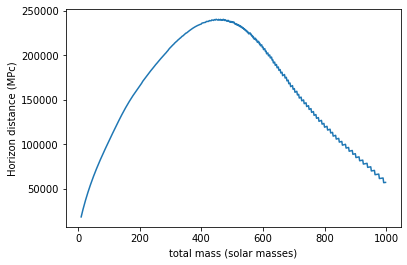

In [9]:
#Plotting
pylab.plot(mass_tot,DH_einstein);
pylab.xlabel('total mass (solar masses)');
pylab.ylabel('Horizon distance (MPc)');

As we can see from the PSD graph for the Einstein telescope, the noise power spectral density is generally lower, explaining the higher horizon distances (see previous comment for the exact relationship between PSD and horizon distance)